## Model Evaluation

model evaluation against RAVDESS, CREMA-D, SAVEE, TESS and EMO-DB

In [1]:
import pandas as pd
import os
import numpy as np
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
import joblib

In [2]:
# Constants
EMOTION_COL = "Emotions"
PATH_COL = "Path"

NEUTRAL = "neutral"
CALM = "calm"
HAPPY = "happy"
SAD = "sad"
ANGRY = "angry"
FEAR = "fear"
DISGUST = "disgust"
SURPRISE = "surprise"
BOREDOM = "boredom"

EMOTIONS = [NEUTRAL, HAPPY, SAD, ANGRY, FEAR, DISGUST]


ZCR = "ZCR"
CHROMA_STFT = "CHROMA_STFT"
MFCC = "MFCC"
RMS = "RMS"
MEL_SPECTROGRAM = "MEL_SPECTROGRAM"
TEAGER_ENERGY_MFCC = "TEAGER_ENERGY_MFCC"

In [3]:
# datasets paths

Ravdess = "/Users/shenalfernando/Documents/FYP/Implementation/ravdess-dataset/"
Crema = "/Users/shenalfernando/Documents/FYP/Implementation/CREMA-D/"
Tess = "/Users/shenalfernando/Documents/FYP/Implementation/TESS/"
Savee = "/Users/shenalfernando/Documents/FYP/Implementation/SAVEE/"
EmoDB = "/Users/shenalfernando/Documents/FYP/Implementation/EmoDB/"

In [4]:
# helper function for EmoDB
def assemble_emo_db(dataset_path):
    berlin_dataset = os.listdir(dataset_path)
    emotions = []
    paths = []
    
    for file in berlin_dataset:
        paths.append(dataset_path + file)
        parts = file.split('.')[0]
        element = parts[5]
        if element == 'W':
            emotions.append(ANGRY)
        elif element == 'E':
            emotions.append(DISGUST)
        elif element == 'A':
            emotions.append(FEAR)
        elif element == 'F':
            emotions.append(HAPPY)
        elif element == 'N':
            emotions.append(NEUTRAL)
        elif element == 'T':
            emotions.append(SAD)
        else:
            emotions.append(BOREDOM)
            
    emotions_df = pd.DataFrame(emotions, columns=[EMOTION_COL])
    paths_df = pd.DataFrame(paths, columns=[PATH_COL])
    
    emo_df = pd.concat([emotions_df, paths_df], axis=1)
    return emo_df

In [5]:
# function to re-assemble the emotion with file_path in RAVDESS dataset
def assemble_ravdess_dataset(dataset_path):
    ravdess_dataset = os.listdir(dataset_path)
    emotions = []
    paths = []

    for directory in ravdess_dataset:
        actor_folder = os.listdir(dataset_path + directory)
        for file in actor_folder:
            file_name = file.split(".")[0]
            parts = file_name.split("-")
            emotions.append(int(parts[2]))  # get the emotion category according to the number present file name
            paths.append(dataset_path + directory + "/" + file)

    # data frame for emotions
    emotion_df = pd.DataFrame(emotions, columns=[EMOTION_COL])

    # data frame for paths
    path_df = pd.DataFrame(paths, columns=[PATH_COL])

    ravdess_df = pd.concat([emotion_df, path_df], axis=1)
    ravdess_df.Emotions.replace({
        1: NEUTRAL,
        2: CALM,
        3: HAPPY,
        4: SAD,
        5: ANGRY,
        6: FEAR,
        7: DISGUST,
        8: SURPRISE
    }, inplace=True)

    return ravdess_df

In [6]:
# function to re-assemble the emotion with file_path in CREMA-D dataset
def assemble_crema_dataset(dataset_path):
    crema_dataset = os.listdir(dataset_path)

    emotions = []
    paths = []

    for file in crema_dataset:
        paths.append(dataset_path + file)
        parts = file.split('_')
        if parts[2] == 'SAD':
            emotions.append(SAD)
        elif parts[2] == 'ANG':
            emotions.append(ANGRY)
        elif parts[2] == 'DIS':
            emotions.append(DISGUST)
        elif parts[2] == 'FEA':
            emotions.append(FEAR)
        elif parts[2] == 'HAP':
            emotions.append(HAPPY)
        elif parts[2] == 'NEU':
            emotions.append(NEUTRAL)
        else:
            emotions.append('Unknown')

    emotions_df = pd.DataFrame(emotions, columns=[EMOTION_COL])
    paths_df = pd.DataFrame(paths, columns=[PATH_COL])

    crema_df = pd.concat([emotions_df, paths_df], axis=1)
    return crema_df

In [7]:
# function to re-assemble the emotion with file_path in TESS dataset
def assemble_tess_dataset(dataset_path):
    tess_dataset = os.listdir(dataset_path)

    emotions = []
    paths = []

    for directory in tess_dataset:
        directories = os.listdir(dataset_path + directory)
        for file in directories:
            file_name = file.split('.')[0]
            emotion = file_name.split('_')[2]
            if emotion == 'ps':
                emotions.append(SURPRISE)
            else:
                emotions.append(emotion)
            paths.append(dataset_path + directory + "/" + file)

    emotions_df = pd.DataFrame(emotions, columns=[EMOTION_COL])
    paths_df = pd.DataFrame(paths, columns=[PATH_COL])

    tess_df = pd.concat([emotions_df, paths_df], axis=1)
    return tess_df

In [8]:
# function to re-assemble the emotion with file_path in SAVEE dataset
def assemble_savee_dataset(dataset_path):
    savee_dataset = os.listdir(dataset_path)

    emotions = []
    paths = []

    for file in savee_dataset:
        paths.append(dataset_path + file)
        parts = file.split('_')[1]
        emotion = parts[:-6]
        if emotion == 'a':
            emotions.append('angry')
        elif emotion == 'd':
            emotions.append('disgust')
        elif emotion == 'f':
            emotions.append('fear')
        elif emotion == 'h':
            emotions.append('happy')
        elif emotion == 'n':
            emotions.append('neutral')
        elif emotion == 'sa':
            emotions.append('sad')
        else:
            emotions.append('surprise')

    emotions_df = pd.DataFrame(emotions, columns=[EMOTION_COL])
    paths_df = pd.DataFrame(paths, columns=[PATH_COL])

    savee_df = pd.concat([emotions_df, paths_df], axis=1)
    return savee_df

In [20]:
# to visualize the dataframe
def visualize_dataset(dataset_path, title, x_label, y_label):
    plt.title(title, size=16)
    sns.countplot(dataset_path, x='Emotions')
    plt.xlabel(x_label, size=12)
    plt.ylabel(y_label, size=12)
    sns.despine(top=True, right=True, left=False, bottom=False)
    plt.show()

In [21]:
# some helper functions for feature extractions combination
# extract MFCC
# extract zero cross rate feature
def extract_zcr_feature(data):
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    return zcr


# extract Chroma_stft
def extract_chroma_stft(data, sample_rate):
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    return chroma_stft



# extract MFCC
def extract_mfcc(data, sample_rate):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc


# extract Root Mean Square Value
def extract_rms(data):
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    return rms


# extract mel spectrogram
def extract_mel_spectrogram(data, sample_rate):
    mel_spectrogram = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    return mel_spectrogram


# Teager Energy Based MFCC feature
def extract_teager_energy_mfcc(data, sample_rate):
    teager_energy = librosa.effects.preemphasis(data)
    teager_mfcc = np.mean(librosa.feature.mfcc(y=teager_energy, sr=sample_rate).T, axis=0)
    return teager_mfcc


# feature combinations
def extract_features(features, signal, sample_rate):
    result = np.array([])
    
    if ZCR in features:
        zcr = extract_zcr_feature(signal)
        result = np.hstack((result, zcr))
        
    if CHROMA_STFT in features:
        chroma_stft = extract_chroma_stft(signal, sample_rate)
        result = np.hstack((result, chroma_stft))
    
    if MFCC in features:
        mfcc_features = extract_mfcc(signal, sample_rate)
        result = np.hstack((result, mfcc_features))
        
    if RMS in features:
        rms = extract_rms(signal)
        result = np.hstack((result, rms))
        
    if MEL_SPECTROGRAM in features:
        mel_spectrogram = extract_mel_spectrogram(signal, sample_rate)
        result = np.hstack((result, mel_spectrogram))
        
    if TEAGER_ENERGY_MFCC in features:
        teager_mfcc = extract_teager_energy_mfcc(signal, sample_rate)
        result = np.hstack((result, teager_mfcc))
        
    return result

def combine_features(path):
    signal, sample_rate = librosa.load(path)
    pure_result = extract_features([ZCR, CHROMA_STFT, MFCC, RMS, MEL_SPECTROGRAM, TEAGER_ENERGY_MFCC], signal, sample_rate)
    
    result = np.array(pure_result)
    return result

In [22]:
# some helper functions for evaluation support
# visualize the confusion matrix report
def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, linecolor='white', cmap='Blues', linewidths=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

In [23]:
def filter_df(df):
    filtered_df = df[df[EMOTION_COL].isin(EMOTIONS)]
    return filtered_df

In [24]:
def get_combined_features(df):
    x, y = [], []
    for path, emotion in zip(df.Path, df.Emotions):
        features = combine_features(path)
        x.append(features)
        y.append(emotion)
    return x, y

In [25]:
def visualize_model_evaluation(x,y,dataset):
    # loading the saved model
    model_path = 'new-tuned-ser-cnn-model.h5'
    cnn_model = load_model(model_path)
    
    # feature arrangement
    features = pd.DataFrame(x)
    features['labels'] = y
    features.to_csv('{}_evaluation_features.csv'.format(dataset), index=False)
    features.head()
    
    labels = features['labels']
    label_mapping = {
    'angry': 0,
    'fear': 1,
    'disgust': 2,
    'sad': 3,
    'happy': 4,
    'neutral': 5
    }
    
    numerical_labels = labels.map(label_mapping)
    
    features['labels'] = numerical_labels
    
    x = features.iloc[: ,:-1].values
    y = features['labels'].values
    
    
    # improving data compatability to model
    # loading the scaler
    scaler = joblib.load('scaler.bin')
    x_test = scaler.transform(x)
    
    x_test = np.expand_dims(x_test, axis=2)
    y_test = y
    
    # predictions against db
    pred_test = cnn_model.predict(x_test)
    y_pred = [np.argmax(i) for i in pred_test]
    df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
    df['Predicted Labels'] = y_pred
    df['Actual Labels'] = y_test
    print(df.head())
    
    display_confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))

In [26]:
# ravdess dataset
ravdess_df = assemble_ravdess_dataset(Ravdess)
ravdess_df.head()

,Emotions,Path
0,angry,/Users/shenalfernando/Documents/FYP/Implementa...
1,fear,/Users/shenalfernando/Documents/FYP/Implementa...
2,fear,/Users/shenalfernando/Documents/FYP/Implementa...
3,angry,/Users/shenalfernando/Documents/FYP/Implementa...
4,disgust,/Users/shenalfernando/Documents/FYP/Implementa...


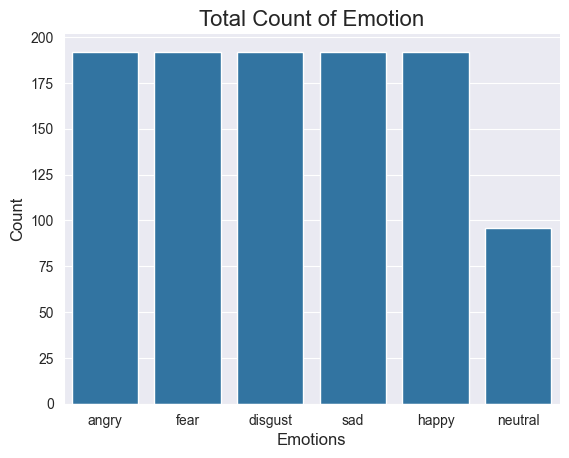

In [27]:
ravdess_filtered = filter_df(ravdess_df)
ravdess_filtered.head()
visualize_dataset(ravdess_filtered, 'Total Count of Emotion', 'Emotions', 'Count')

In [28]:
ravdess_features_x, ravdess_features_y = get_combined_features(ravdess_filtered)

In [29]:
len(ravdess_features_x), len(ravdess_features_y), ravdess_filtered.Path.shape

(1056, 1056, (1056,))

33/33 [==============================] - 0s 8ms/step
   Predicted Labels  Actual Labels
0                 0              0
1                 1              1
2                 1              1
3                 0              0
4                 2              2


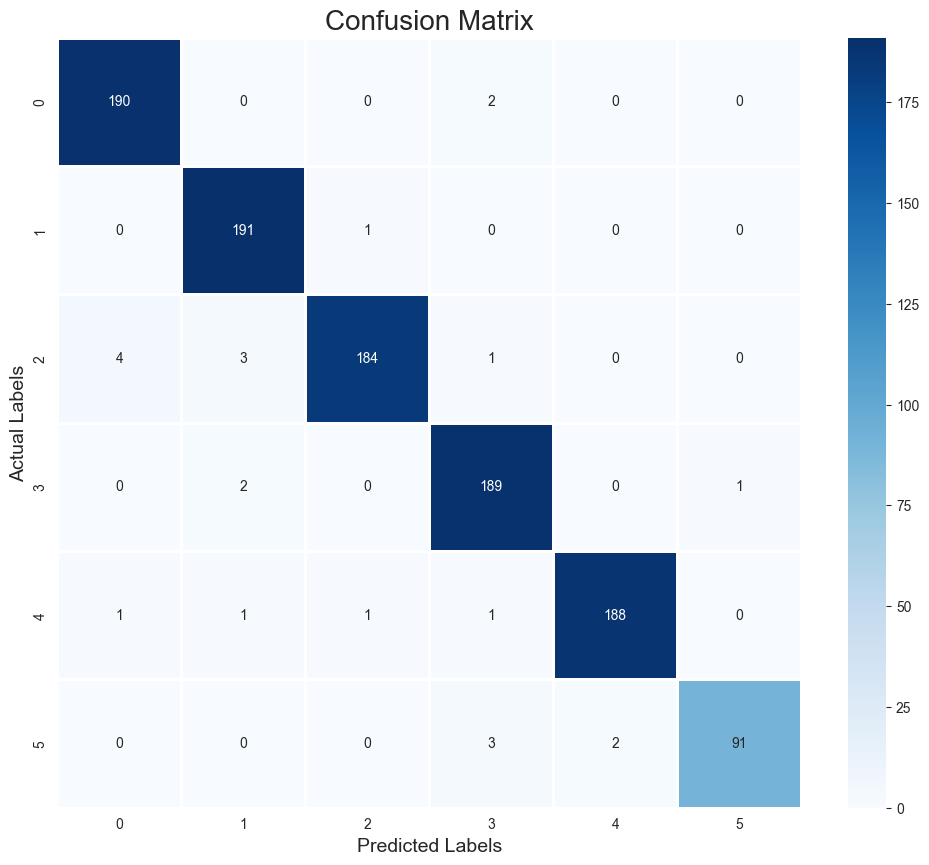

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       192
           1       0.97      0.99      0.98       192
           2       0.99      0.96      0.97       192
           3       0.96      0.98      0.97       192
           4       0.99      0.98      0.98       192
           5       0.99      0.95      0.97        96

    accuracy                           0.98      1056
   macro avg       0.98      0.98      0.98      1056
weighted avg       0.98      0.98      0.98      1056


In [30]:
visualize_model_evaluation(ravdess_features_x, ravdess_features_y, "ravdess")

In [31]:
# crema-d dataset
crema_df = assemble_crema_dataset(Crema)
crema_df.head()

,Emotions,Path
0,angry,/Users/shenalfernando/Documents/FYP/Implementa...
1,angry,/Users/shenalfernando/Documents/FYP/Implementa...
2,neutral,/Users/shenalfernando/Documents/FYP/Implementa...
3,neutral,/Users/shenalfernando/Documents/FYP/Implementa...
4,disgust,/Users/shenalfernando/Documents/FYP/Implementa...


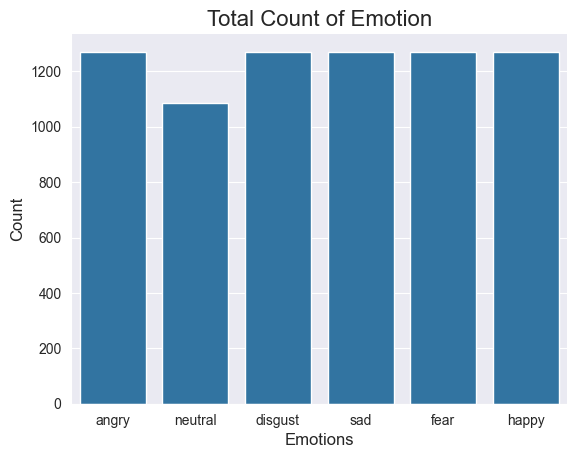

In [32]:
crema_filtered = filter_df(crema_df)
crema_filtered.head()
visualize_dataset(crema_filtered, 'Total Count of Emotion', 'Emotions', 'Count')

In [33]:
crema_features_x, crema_features_y = get_combined_features(crema_filtered)

/opt/anaconda3/envs/tf_env/lib/python3.8/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [34]:
len(crema_features_x), len(crema_features_y), crema_filtered.Path.shape

(7442, 7442, (7442,))

233/233 [==============================] - 2s 8ms/step
   Predicted Labels  Actual Labels
0                 0              0
1                 0              0
2                 5              5
3                 5              5
4                 2              2


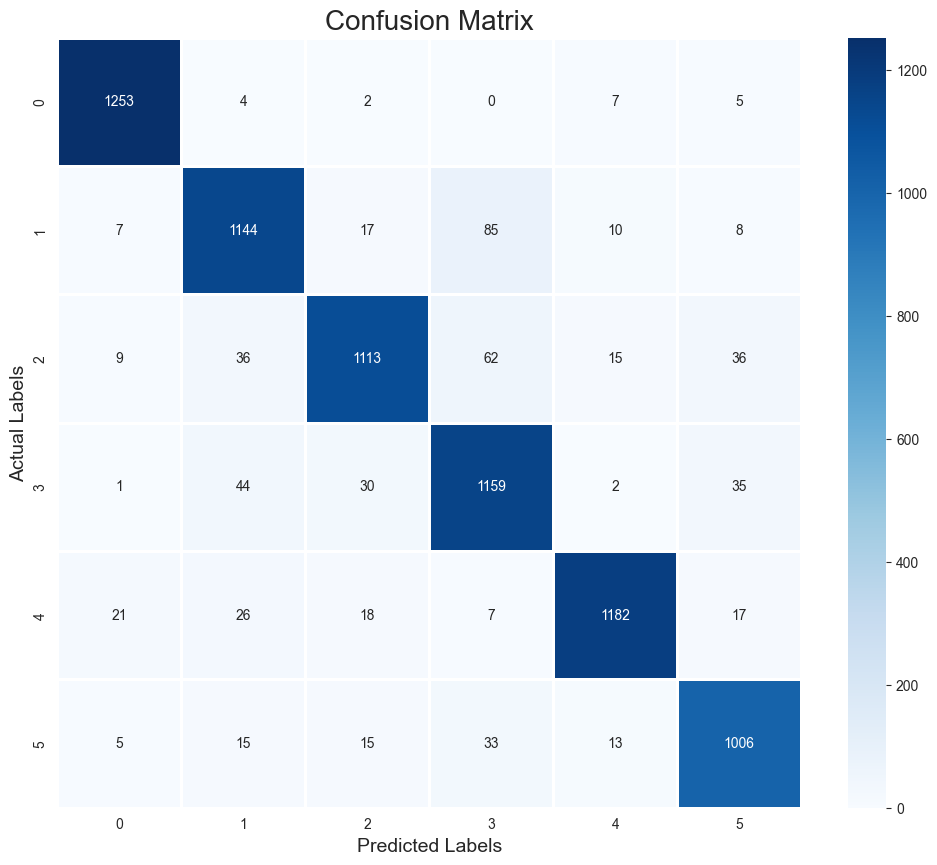

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1271
           1       0.90      0.90      0.90      1271
           2       0.93      0.88      0.90      1271
           3       0.86      0.91      0.89      1271
           4       0.96      0.93      0.95      1271
           5       0.91      0.93      0.92      1087

    accuracy                           0.92      7442
   macro avg       0.92      0.92      0.92      7442
weighted avg       0.92      0.92      0.92      7442


In [35]:
visualize_model_evaluation(crema_features_x,crema_features_y, "crema")

In [36]:
# tess dataset
tess_df = assemble_tess_dataset(Tess)
tess_df.head()

,Emotions,Path
0,disgust,/Users/shenalfernando/Documents/FYP/Implementa...
1,disgust,/Users/shenalfernando/Documents/FYP/Implementa...
2,disgust,/Users/shenalfernando/Documents/FYP/Implementa...
3,disgust,/Users/shenalfernando/Documents/FYP/Implementa...
4,disgust,/Users/shenalfernando/Documents/FYP/Implementa...


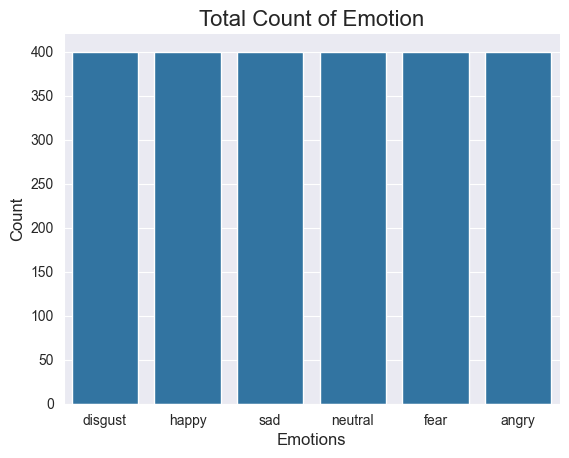

In [37]:
tess_filtered = filter_df(tess_df)
tess_filtered.head()
visualize_dataset(tess_filtered, 'Total Count of Emotion', 'Emotions', 'Count')

In [38]:
tess_features_x, tess_features_y = get_combined_features(tess_filtered)

In [39]:
len(tess_features_x), len(tess_features_y), tess_filtered.Path.shape

(2400, 2400, (2400,))

75/75 [==============================] - 1s 8ms/step
   Predicted Labels  Actual Labels
0                 2              2
1                 2              2
2                 2              2
3                 2              2
4                 2              2


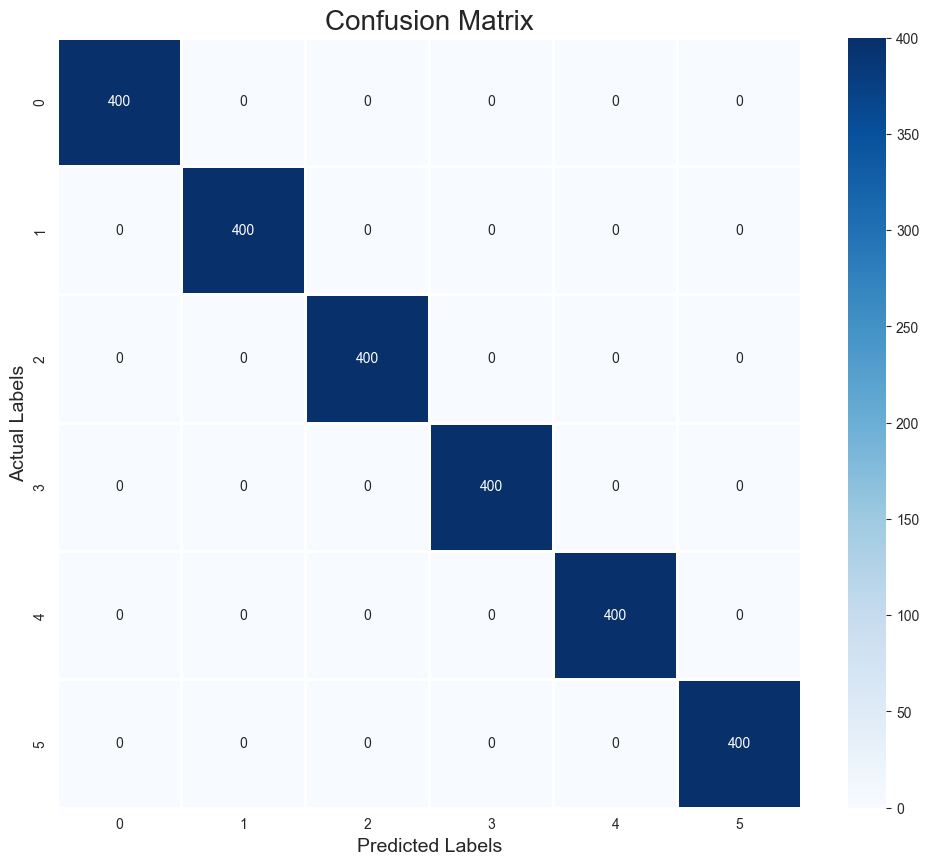

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       400
           1       1.00      1.00      1.00       400
           2       1.00      1.00      1.00       400
           3       1.00      1.00      1.00       400
           4       1.00      1.00      1.00       400
           5       1.00      1.00      1.00       400

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400


In [40]:
visualize_model_evaluation(tess_features_x, tess_features_y, "tess")

In [41]:
# savee dataset
savee_df = assemble_savee_dataset(Savee)
savee_df.head()

,Emotions,Path
0,sad,/Users/shenalfernando/Documents/FYP/Implementa...
1,sad,/Users/shenalfernando/Documents/FYP/Implementa...
2,neutral,/Users/shenalfernando/Documents/FYP/Implementa...
3,surprise,/Users/shenalfernando/Documents/FYP/Implementa...
4,neutral,/Users/shenalfernando/Documents/FYP/Implementa...


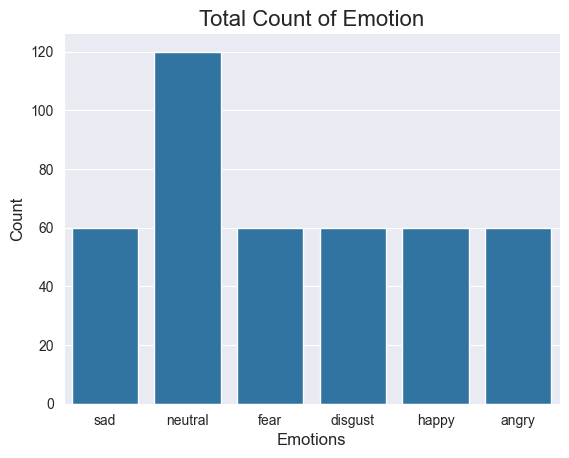

In [42]:
savee_filtered = filter_df(savee_df)
savee_filtered.head()
visualize_dataset(savee_filtered, 'Total Count of Emotion', 'Emotions', 'Count')

In [43]:
savee_features_x, savee_features_y = get_combined_features(savee_filtered)

In [44]:
len(savee_features_x), len(savee_features_y), savee_filtered.Path.shape

(420, 420, (420,))

14/14 [==============================] - 0s 8ms/step
   Predicted Labels  Actual Labels
0                 3              3
1                 3              3
2                 5              5
3                 5              5
4                 5              5


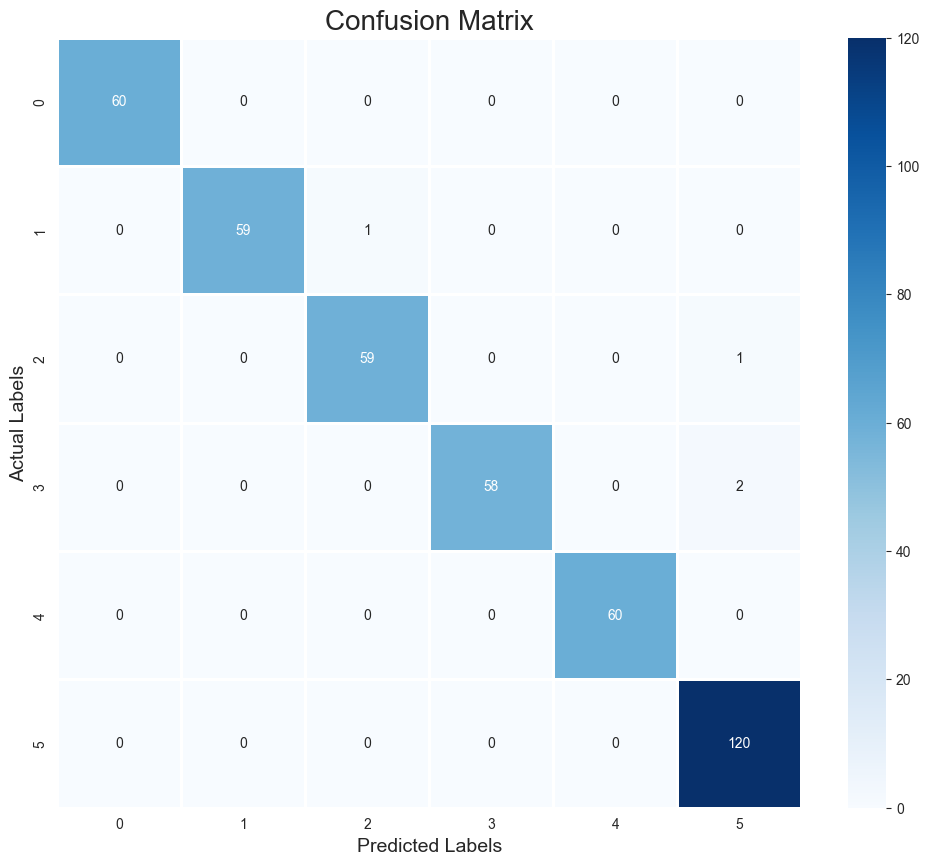

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      0.98      0.99        60
           2       0.98      0.98      0.98        60
           3       1.00      0.97      0.98        60
           4       1.00      1.00      1.00        60
           5       0.98      1.00      0.99       120

    accuracy                           0.99       420
   macro avg       0.99      0.99      0.99       420
weighted avg       0.99      0.99      0.99       420


In [45]:
visualize_model_evaluation(savee_features_x, savee_features_y, "savee")

In [46]:
# emo db
emo_db_df = assemble_emo_db(EmoDB)
emo_db_df.head()

,Emotions,Path
0,boredom,/Users/shenalfernando/Documents/FYP/Implementa...
1,angry,/Users/shenalfernando/Documents/FYP/Implementa...
2,fear,/Users/shenalfernando/Documents/FYP/Implementa...
3,disgust,/Users/shenalfernando/Documents/FYP/Implementa...
4,angry,/Users/shenalfernando/Documents/FYP/Implementa...


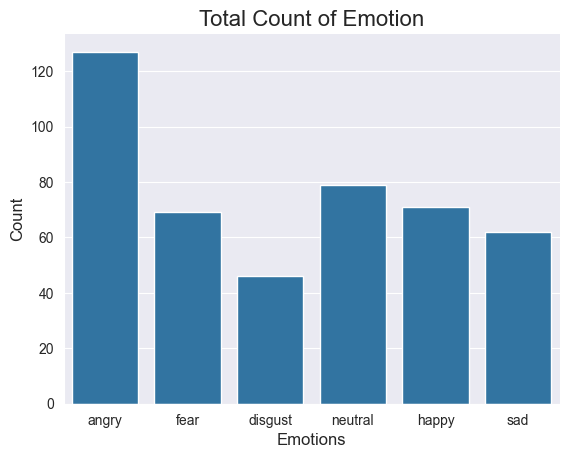

In [47]:
emo_db_filtered = filter_df(emo_db_df)
emo_db_filtered.head()
visualize_dataset(emo_db_filtered, 'Total Count of Emotion', 'Emotions', 'Count')

In [48]:
emo_db_features_x, emo_db_features_y = get_combined_features(emo_db_filtered)

In [49]:
len(emo_db_features_x), len(emo_db_features_y), emo_db_filtered.Path.shape

(454, 454, (454,))

15/15 [==============================] - 0s 8ms/step
   Predicted Labels  Actual Labels
0                 0              0
1                 0              1
2                 0              2
3                 0              0
4                 0              5


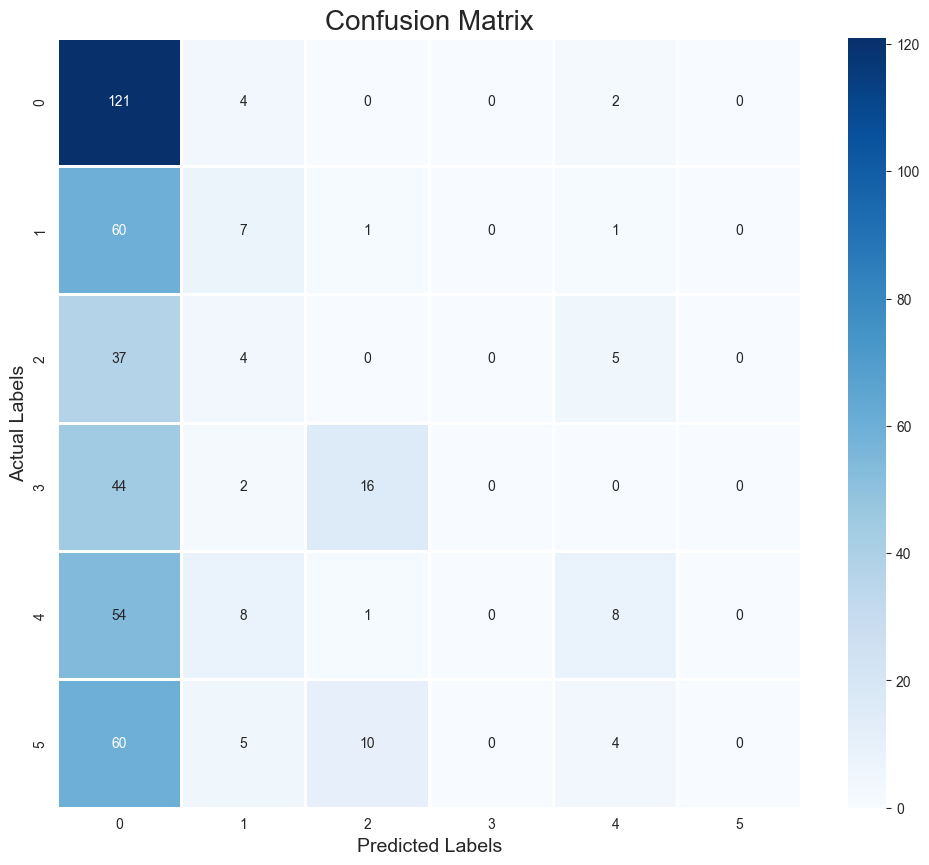

              precision    recall  f1-score   support

           0       0.32      0.95      0.48       127
           1       0.23      0.10      0.14        69
           2       0.00      0.00      0.00        46
           3       0.00      0.00      0.00        62
           4       0.40      0.11      0.18        71
           5       0.00      0.00      0.00        79

    accuracy                           0.30       454
   macro avg       0.16      0.19      0.13       454
weighted avg       0.19      0.30      0.18       454


/opt/anaconda3/envs/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [50]:
visualize_model_evaluation(emo_db_features_x, emo_db_features_y, "emo_db")